Shape: (480000, 4)
Sample rate: 48000 Hz
Tile (90, -180) to (70, -160): energy saliency = 59.1463, contrast saliency = 13.0134, temporal saliency = 37.9406,               harmonic saliency = 20.7104, specetral flatness = 0.0118, spectral centroid saliency = 3638.0922, specetral bandwidth = 5635.5539
Tile (90, -160) to (70, -140): energy saliency = 58.9878, contrast saliency = 13.0210, temporal saliency = 36.6304,               harmonic saliency = 20.8759, specetral flatness = 0.0117, spectral centroid saliency = 3617.7610, specetral bandwidth = 5625.7561
Tile (90, -140) to (70, -120): energy saliency = 58.7895, contrast saliency = 12.9425, temporal saliency = 35.1701,               harmonic saliency = 21.1003, specetral flatness = 0.0115, spectral centroid saliency = 3583.2067, specetral bandwidth = 5605.9629
Tile (90, -120) to (70, -100): energy saliency = 58.5797, contrast saliency = 12.8866, temporal saliency = 33.9119,               harmonic saliency = 21.3530, specetral flatness =

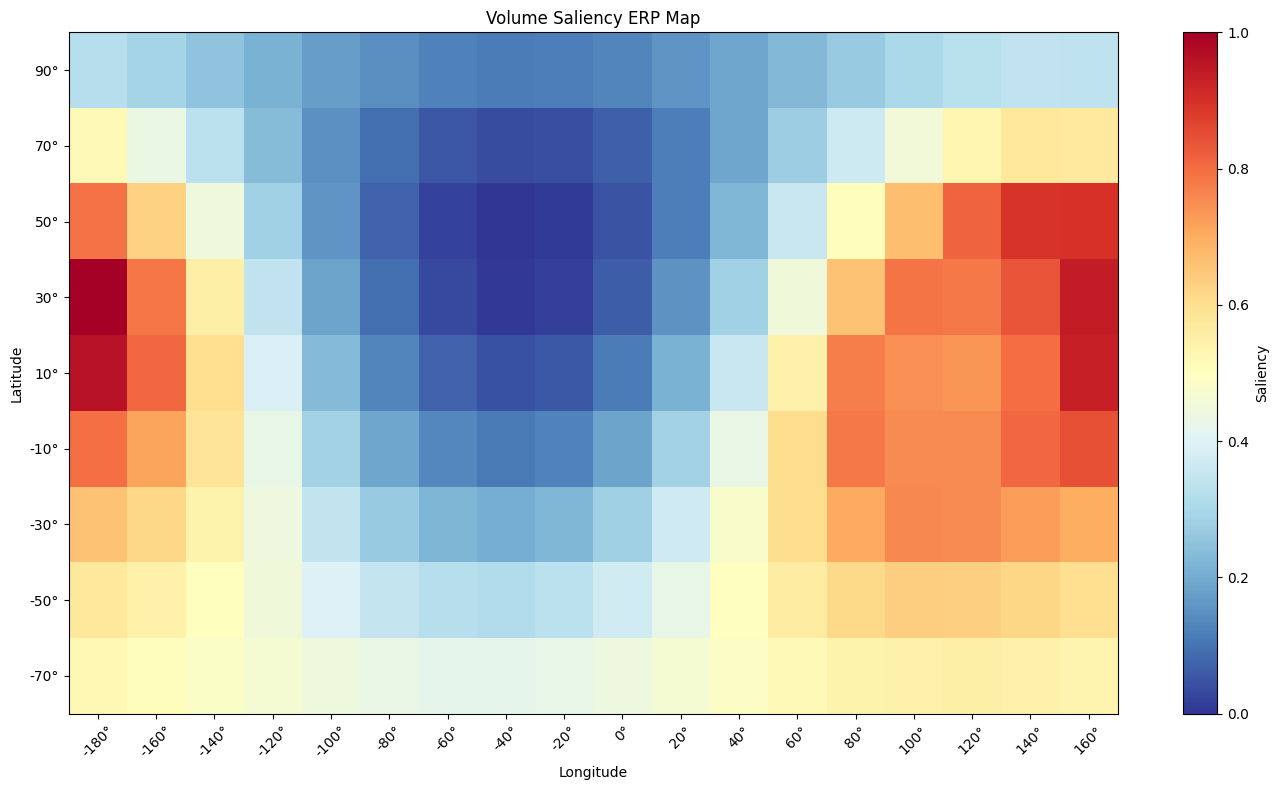

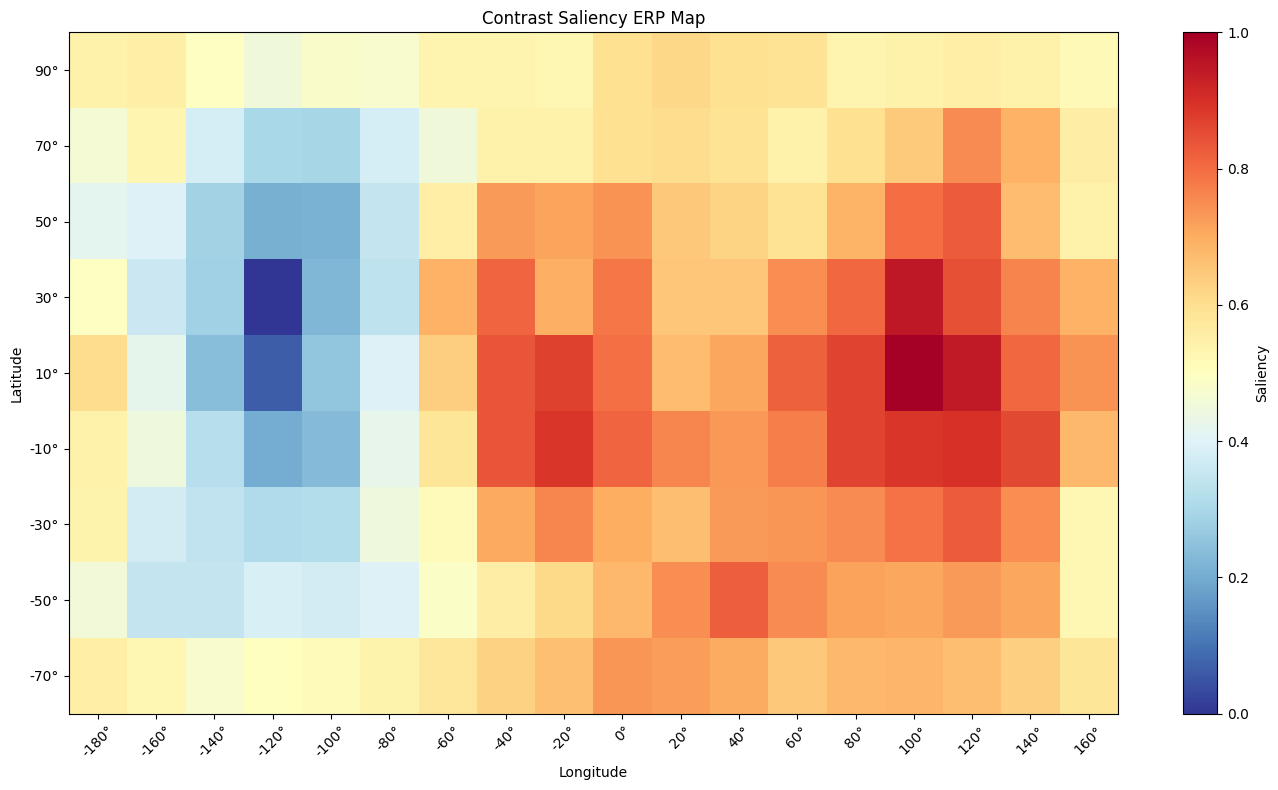

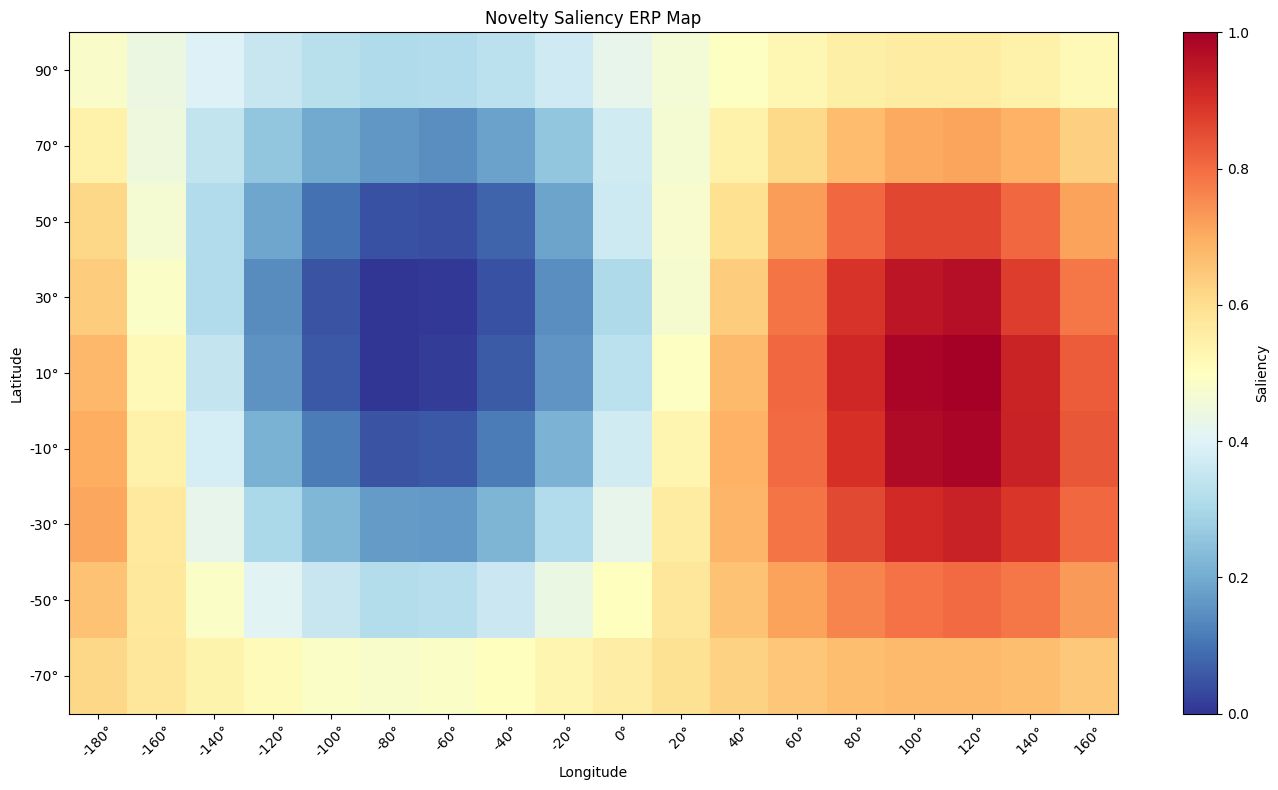

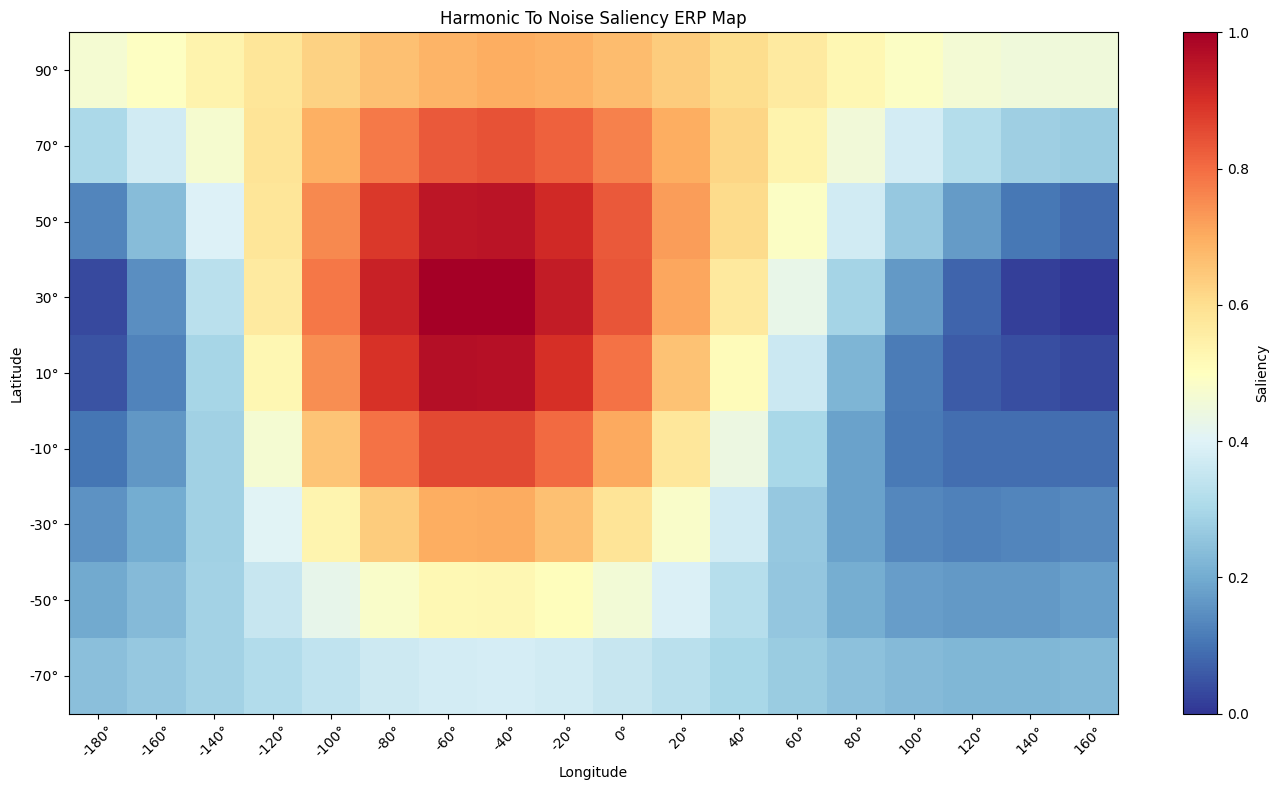

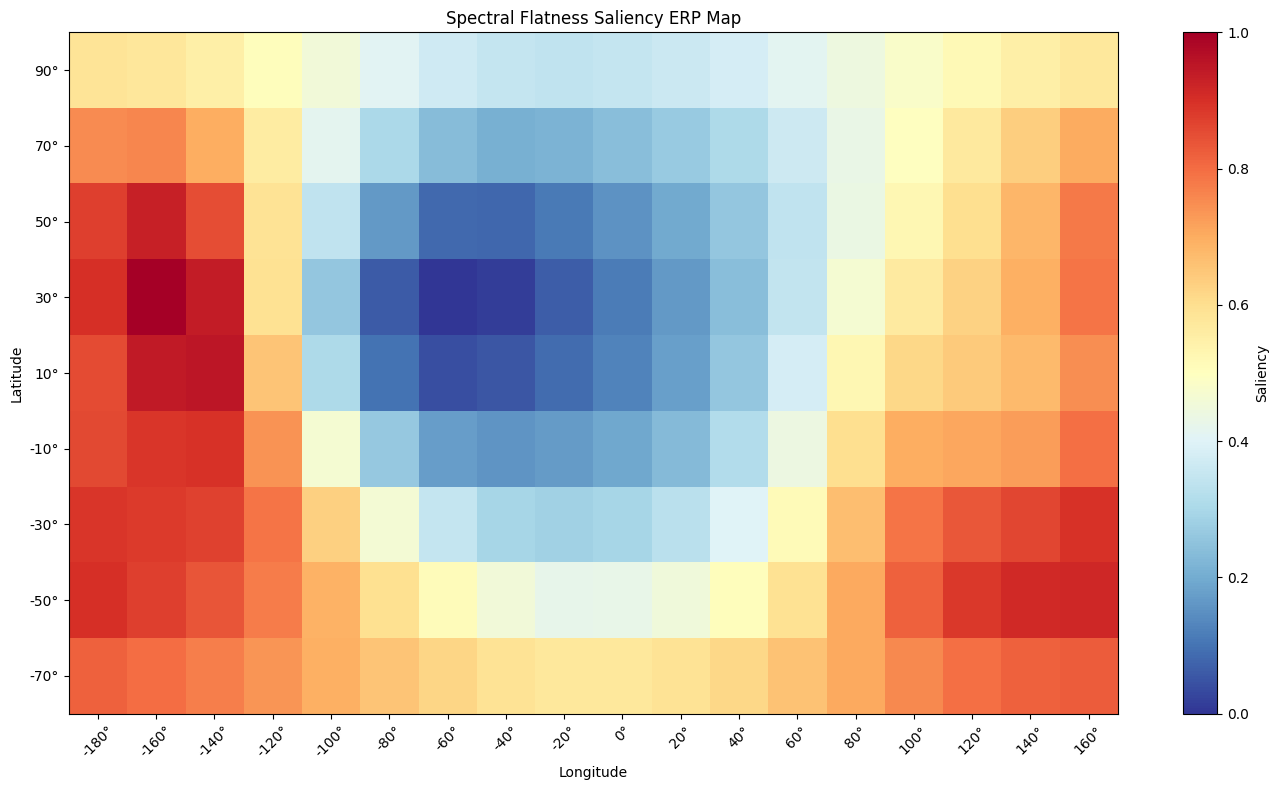

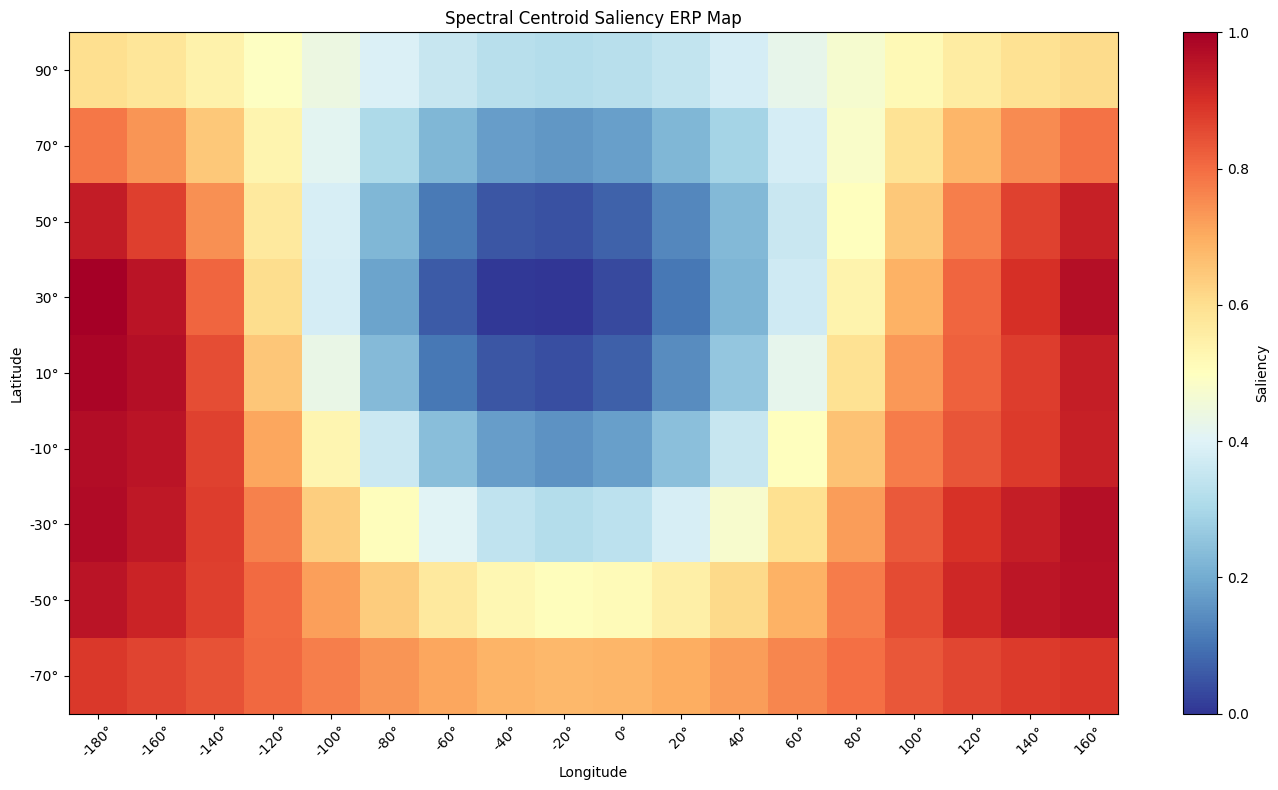

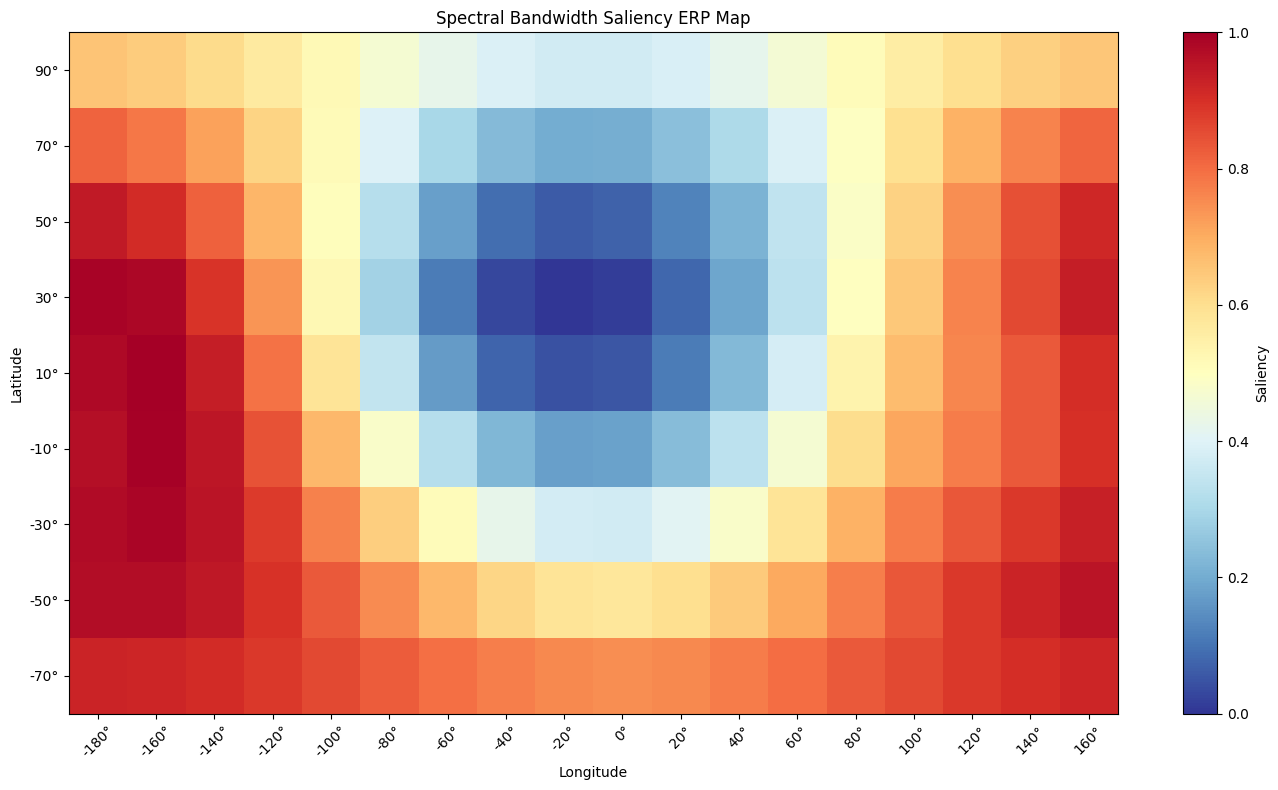

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import soundfile as sf
import librosa
from scipy.integrate import dblquad

# Load the .wav file
data, samplerate = sf.read("SaliencySoundTest/ambisonic_audio_4ch_10.wav")

def compute_audio_at_direction(W: np.ndarray, X: np.ndarray, 
                               Y: np.ndarray, Z: np.ndarray,
                               top_left: tuple, bottom_right: tuple,
                               center_time: float, sampleRate: int,
                               window_sec: float = 0.1) -> np.ndarray:
    """
    Compute audio waveform for a tile and around a specific time.
    
    Parameters:
        center_time: time in seconds to center the window
        window_sec: half-length of window (seconds) to extract
    """
    top_left_lat, top_left_lon = top_left
    bottom_right_lat, bottom_right_lon = bottom_right
    
    # Convert bounds to radians
    lat_min_rad = np.radians(bottom_right_lat)
    lat_max_rad = np.radians(top_left_lat)
    lon_min_rad = np.radians(top_left_lon)
    lon_max_rad = np.radians(bottom_right_lon)
    
    # Compute patch area (steradians)
    area = (lon_max_rad - lon_min_rad) * (np.sin(lat_max_rad) - np.sin(lat_min_rad))
    
    # Integrate Y_W over the region
    integral_Y_W, _ = dblquad(lambda lon, lat: np.cos(lat), lat_min_rad, lat_max_rad,
                              lambda _: lon_min_rad, lambda _: lon_max_rad)
    integral_Y_X, _ = dblquad(lambda lon, lat: np.cos(lat)*np.cos(lon)*np.cos(lat), lat_min_rad, lat_max_rad,
                              lambda _: lon_min_rad, lambda _: lon_max_rad)
    integral_Y_Y, _ = dblquad(lambda lon, lat: np.cos(lat)*np.sin(lon)*np.cos(lat), lat_min_rad, lat_max_rad,
                              lambda _: lon_min_rad, lambda _: lon_max_rad)
    integral_Y_Z, _ = dblquad(lambda lon, lat: np.sin(lat)*np.cos(lat), lat_min_rad, lat_max_rad,
                              lambda _: lon_min_rad, lambda _: lon_max_rad)
    
    # Convert time to sample indices
    center_sample = int(center_time * sampleRate)
    half_window_samples = int(window_sec * sampleRate)
    start = max(center_sample - half_window_samples, 0)
    end = min(center_sample + half_window_samples, len(W))
    
    # Extract the waveform slice
    W_slice = W[start:end]
    X_slice = X[start:end]
    Y_slice = Y[start:end]
    Z_slice = Z[start:end]
    
    # Reconstruct waveform for this tile
    wave = (integral_Y_W * W_slice + integral_Y_X * X_slice +
            integral_Y_Y * Y_slice + integral_Y_Z * Z_slice) / area
    
    return wave

print(f"Shape: {data.shape}")   # (num_samples, 4)
print(f"Sample rate: {samplerate} Hz")

# Split into channels
W = data[:, 0]
X = data[:, 1]
Y = data[:, 2]
Z = data[:, 3]

def computeHNR(frame):
    """
    Compute HNR for a single frame using autocorrelation.
    HNR = 10 * log10(energy_harmonic / energy_noise)
    """
    frame = frame - np.mean(frame)  # remove DC
    if np.all(frame == 0):
        return 0.0

    # FFT-based autocorrelation
    autocorr = np.fft.irfft(np.fft.rfft(frame) * np.conj(np.fft.rfft(frame)))
    autocorr = autocorr / np.max(np.abs(autocorr))  # normalize

    # Harmonic energy = max autocorr (excluding lag 0)
    harmonic_energy = np.max(autocorr[1:])
    # Noise energy = lag 0 minus harmonic energy
    noise_energy = autocorr[0] - harmonic_energy
    if noise_energy <= 0:
        return 40.0  # cap to a reasonable max
    return 10 * np.log10(harmonic_energy / noise_energy)


def processWave(wave, sampleRate):
    windowSize = 2048
    hopSize = 100
    
    # converts this to a Short-Time Fourier Transform. Tells you how much eergy has at each frequency over time.
    # does this by going through windows. Length of each window defined by n_fft. Then, shifts window to right by length
    # hop length. at each window, computes how much of each frequency is present.
    # final value is 2D array of rows being each frequency, columns being time (which is now the windows), so value being amplitude/energy for that time and frequency
    stftWave = np.abs(librosa.stft(wave, n_fft=windowSize, hop_length=hopSize))
    # when we get the mel, that just converts all the frequencies to 128 possible onces, which are moreso frequencies humans can hear. So compressing
    # the frequencies from a large number of frequencies to a smaller number, in this case n_mels amount
    mel = librosa.feature.melspectrogram(S = stftWave, sr= sampleRate, n_mels = 128)
    # converts from power scaling of audio to decibel scaling, cause humans perceive in moreso logarithm of audio (so higher sounds kinda taper off to us)
    logMel = librosa.power_to_db(mel, ref=np.max)

    # gets overall frame energy, including amplitude
    volumeNorm = np.mean((logMel + 80), axis=0)
    # gets the contrast in energy between frequencies within a specific frequency band, so where some frequencies bands may have parts of high energy frequencies, while other parts are low energy
    contrast = librosa.feature.spectral_contrast(S = stftWave, sr=sampleRate)
    # combines the difference frequency bands to get a average contrast for that time frame
    contrast = np.mean(contrast, axis=0)
    # basically gets how much the sound chagnes over time. Does this by getting differnece over time fimes with np.diff, squaring that value, and getting its sum
    temporal_novelty = np.sum(np.diff(logMel, axis=1) ** 2, axis=0)
    # do this to add an extra value cause rn, the length is T - 1, since you're getting difference between frames. So add 1 to get it to T length
    temporal_novelty = np.insert(temporal_novelty, 0, 0)

    # this gets how noise like a sound is, whether it's tonal or liek white noise. A tonal sound is one that just
    # stands out, like through sharp peaks.
    spectral_flatness = librosa.feature.spectral_flatness(y=wave, n_fft=windowSize, hop_length= hopSize)
    # gets the average frequency weighted by amplitude, how "bright" the sound is, sees if the audio tends to have more high frequency or low frequency sounds
    centroid = librosa.feature.spectral_centroid(S=stftWave, sr=sampleRate)
    # indicates the range of frequencies present, so if the frequencies are more concentrated or spread out
    bandwidth = librosa.feature.spectral_bandwidth(S=stftWave, sr=sampleRate)



    # Compute HNR per frame. HNR is how harmonic the sound is, if its harmonic, with a pattern, or more noisy.
    # different from spectral flatness in that it measures if its harmonic, as opposed to tonal. Basically if there's like
    # a repeating pattern that identifies the town
    hnr_values = []
    num_frames = stftWave.shape[1]
    for i in range(num_frames):
        frame = wave[i*hopSize : i*hopSize + windowSize]
        if len(frame) < 2:
            continue
        hnr_values.append(computeHNR(frame))
    hnr_values = np.array(hnr_values)
    
    return (np.mean(volumeNorm), np.mean(contrast), np.mean(temporal_novelty), np.mean(hnr_values), np.mean(spectral_flatness), np.mean(centroid), np.mean(bandwidth))

# Create a grid of saliency values
latitudes = list(range(90, -90, -20))
longitudes = list(range(-180, 180, 20))

volume_saliency_grid = np.zeros((len(latitudes), len(longitudes)))
contrast_saliency_grid = np.zeros((len(latitudes), len(longitudes)))
novelty_saliency_grid = np.zeros((len(latitudes), len(longitudes)))
harmonic_saliency_grid = np.zeros((len(latitudes), len(longitudes)))
flatness_saliency_grid = np.zeros((len(latitudes), len(longitudes)))
centroid_saliency_grid = np.zeros((len(latitudes), len(longitudes)))
bandwidth_saliency_grid = np.zeros((len(latitudes), len(longitudes)))

# Compute saliency for each tile
for lat_idx, latitude in enumerate(latitudes):
    for lon_idx, longitude in enumerate(longitudes):
        topLeft = (latitude, longitude)
        bottomRight = (latitude - 20, longitude + 20)
        wave = compute_audio_at_direction(W, X, Y, Z, topLeft, bottomRight, 7, samplerate)
        volumeSaliency, contrastSaliency, noveltySaliency, harmonicSaliency, flatnessSaliency, centroidSaliency, bandwidthSaliency = processWave(wave, samplerate)
        volume_saliency_grid[lat_idx, lon_idx] = volumeSaliency
        contrast_saliency_grid[lat_idx, lon_idx] = contrastSaliency
        novelty_saliency_grid[lat_idx, lon_idx] = noveltySaliency
        harmonic_saliency_grid[lat_idx, lon_idx] = harmonicSaliency
        flatness_saliency_grid[lat_idx, lon_idx] = flatnessSaliency
        centroid_saliency_grid[lat_idx, lon_idx] = centroidSaliency
        bandwidth_saliency_grid[lat_idx, lon_idx] = bandwidthSaliency

        
        print(f"Tile {topLeft} to {bottomRight}: energy saliency = {volumeSaliency:.4f}, contrast saliency = {contrastSaliency:.4f}, temporal saliency = {noveltySaliency:.4f}, \
              harmonic saliency = {harmonicSaliency:.4f}, specetral flatness = {flatnessSaliency:.4f}, spectral centroid saliency = {centroidSaliency:.4f}, specetral bandwidth = {bandwidthSaliency:.4f}")


def printHeatmap(name, grid):
    grid = grid - np.min(grid)
    grid = grid / np.max(grid)

    # Create ERP-style heatmap
    fig, ax = plt.subplots(figsize=(14, 8))
    # Plot heatmap
    im = ax.imshow(grid, cmap='RdYlBu_r', aspect='auto', origin='upper')

    # Set ticks and labels
    ax.set_xticks(range(len(longitudes)))
    ax.set_yticks(range(len(latitudes)))
    ax.set_xticklabels([f'{lon}°' for lon in longitudes], rotation=45)
    ax.set_yticklabels([f'{lat}°' for lat in latitudes])

    # Labels
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'{name} Saliency ERP Map')

    # Colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Saliency')

    plt.tight_layout()
    plt.show()

printHeatmap("Volume", volume_saliency_grid)

printHeatmap("Contrast", contrast_saliency_grid)

printHeatmap("Novelty", novelty_saliency_grid)

printHeatmap("Harmonic To Noise", harmonic_saliency_grid)

printHeatmap("Spectral Flatness", flatness_saliency_grid)

printHeatmap("Spectral Centroid", centroid_saliency_grid)

printHeatmap("Spectral Bandwidth", bandwidth_saliency_grid)